In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import LineString, Point
import geopandas as gpd
import folium
from folium.plugins import HeatMap
import plotly.express as px
import plotly.graph_objects as go

# Set plotting style
# plt.style.use('seaborn-whitegrid')
# sns.set_style('whitegrid')

# General

In [71]:
import json
import pandas as pd

# Load the station information data
with open('../data/bicycle_stations/Informacio_Estacions_Bicing_securitzat.json', 'r') as f:
    stations_info_json = json.load(f)
    
# Load the station status data
with open('../data/bicycle_stations/Estat_Estacions_Bicing_securitzat.json', 'r') as f:
    stations_status_json = json.load(f)
    
# Access the stations list from the nested structure
stations_info_list = stations_info_json["data"]["stations"]
stations_status_list = stations_status_json["data"]["stations"]
    
# Convert the lists of stations to DataFrames
stations_info_df = pd.DataFrame(stations_info_list)
stations_status_df = pd.DataFrame(stations_status_list)

# Flatten the nested num_bikes_available_types dictionary in the status dataframe
stations_status_df['num_mechanical_bikes'] = stations_status_df['num_bikes_available_types'].apply(lambda x: x['mechanical'])
stations_status_df['num_ebikes'] = stations_status_df['num_bikes_available_types'].apply(lambda x: x['ebike'])

# Drop the original nested column
stations_status_df.drop('num_bikes_available_types', axis=1, inplace=True)

# Merge the two dataframes on station_id
merged_stations_df = pd.merge(stations_info_df, stations_status_df, on='station_id', suffixes=('_info', '_status'))

# Remove duplicate columns (is_charging_station appears in both datasets)
if 'is_charging_station_status' in merged_stations_df.columns:
    merged_stations_df.drop('is_charging_station_status', axis=1, inplace=True)

# Display information about the merged dataset
print(f"Number of bike stations: {len(merged_stations_df)}")
print(f"Number of columns: {len(merged_stations_df.columns)}")
merged_stations_df.head()

Number of bike stations: 512
Number of columns: 26


,station_id,name,physical_configuration,lat,lon,altitude,address,cross_street,post_code,capacity,...,num_bikes_available,num_docks_available,last_reported,status,is_installed,is_renting,is_returning,traffic,num_mechanical_bikes,num_ebikes
0,1,"GRAN VIA CORTS CATALANES, 760",ELECTRICBIKESTATION,41.397978,2.180107,16.0,"GRAN VIA CORTS CATALANES, 760",02-Eixample/05-el Fort Pienc,08013,46,...,29,15,1742831398,IN_SERVICE,1,1,1,None,26,3
1,2,"C/ ROGER DE FLOR, 126",ELECTRICBIKESTATION,41.395488,2.177198,17.0,"C/ ROGER DE FLOR, 126",02-Eixample/05-el Fort Pienc,08013,28,...,2,25,1742831319,IN_SERVICE,1,1,1,None,2,0
2,3,"C/ NÀPOLS, 82",ELECTRICBIKESTATION,41.394156,2.181331,11.0,"C/ NÀPOLS, 82",02-Eixample/05-el Fort Pienc,08013,27,...,11,14,1742831369,IN_SERVICE,1,1,1,None,10,1
3,4,"C/ RIBES, 13",ELECTRICBIKESTATION,41.393317,2.181248,8.0,"C/ RIBES, 13",02-Eixample/05-el Fort Pienc,08013,21,...,9,9,1742831321,IN_SERVICE,1,1,1,None,7,2
4,5,"PG. LLUIS COMPANYS, 11 (ARC TRIOMF)",ELECTRICBIKESTATION,41.391103,2.180176,7.0,"PG. LLUIS COMPANYS, 11 (ARC TRIOMF)","01-CiutatVella/04-Sant Pere, Santa Caterina i ...",08018,39,...,11,27,1742831365,IN_SERVICE,1,1,1,None,11,0


In [72]:
print("Dataset Shape:", merged_stations_df.shape)
print("\nData Types:")
print(merged_stations_df.dtypes)


Dataset Shape: (512, 26)

Data Types:
station_id                    int64
name                         object
physical_configuration       object
lat                         float64
lon                         float64
altitude                    float64
address                      object
cross_street                 object
post_code                    object
capacity                      int64
is_charging_station_info       bool
short_name                    int64
nearby_distance             float64
_ride_code_support             bool
rental_uris                  object
is_valet_station             object
num_bikes_available           int64
num_docks_available           int64
last_reported                 int64
status                       object
is_installed                  int64
is_renting                    int64
is_returning                  int64
traffic                      object
num_mechanical_bikes          int64
num_ebikes                    int64
dtype: object


In [73]:
print("\nMissing Values:")
print(merged_stations_df.isnull().sum())



Missing Values:
station_id                    0
name                          0
physical_configuration        0
lat                           0
lon                           0
altitude                      9
address                       0
cross_street                  0
post_code                     0
capacity                      0
is_charging_station_info      0
short_name                    0
nearby_distance               0
_ride_code_support            0
rental_uris                 512
is_valet_station            512
num_bikes_available           0
num_docks_available           0
last_reported                 0
status                        0
is_installed                  0
is_renting                    0
is_returning                  0
traffic                     512
num_mechanical_bikes          0
num_ebikes                    0
dtype: int64


In [74]:
print("\nBasic Statistics:")
merged_stations_df.describe()


Basic Statistics:


,station_id,lat,lon,altitude,capacity,short_name,nearby_distance,num_bikes_available,num_docks_available,last_reported,is_installed,is_renting,is_returning,num_mechanical_bikes,num_ebikes
count,512.000000,512.000000,512.000000,503.000000,512.000000,512.000000,512.000000,512.000000,512.000000,5.120000e+02,512.0,512.000000,512.000000,512.000000,512.000000
mean,266.101562,41.399174,2.167822,35.853877,26.982422,265.898438,996.097656,7.644531,17.212891,1.742831e+09,1.0,0.998047,0.998047,4.691406,2.988281
std,152.291799,0.021293,0.024539,32.637771,6.619494,151.936931,62.376377,7.792478,8.205029,3.466657e+02,0.0,0.044194,0.044194,6.923293,3.387536
min,1.000000,41.346775,2.109154,2.000000,12.000000,1.000000,1.000000,0.000000,0.000000,1.742824e+09,1.0,0.000000,0.000000,0.000000,0.000000
25%,134.750000,41.383174,2.148619,9.000000,23.000000,134.750000,1000.000000,2.000000,12.000000,1.742831e+09,1.0,1.000000,1.000000,0.000000,1.000000
50%,267.500000,41.395441,2.170320,25.000000,27.000000,267.500000,1000.000000,5.000000,18.000000,1.742831e+09,1.0,1.000000,1.000000,2.000000,2.000000
75%,396.250000,41.411782,2.186762,53.500000,30.000000,396.250000,1000.000000,11.000000,23.000000,1.742831e+09,1.0,1.000000,1.000000,7.000000,4.000000
max,544.000000,41.462095,2.220691,166.000000,54.000000,527.000000,1000.000000,52.000000,48.000000,1.742831e+09,1.0,1.000000,1.000000,48.000000,25.000000


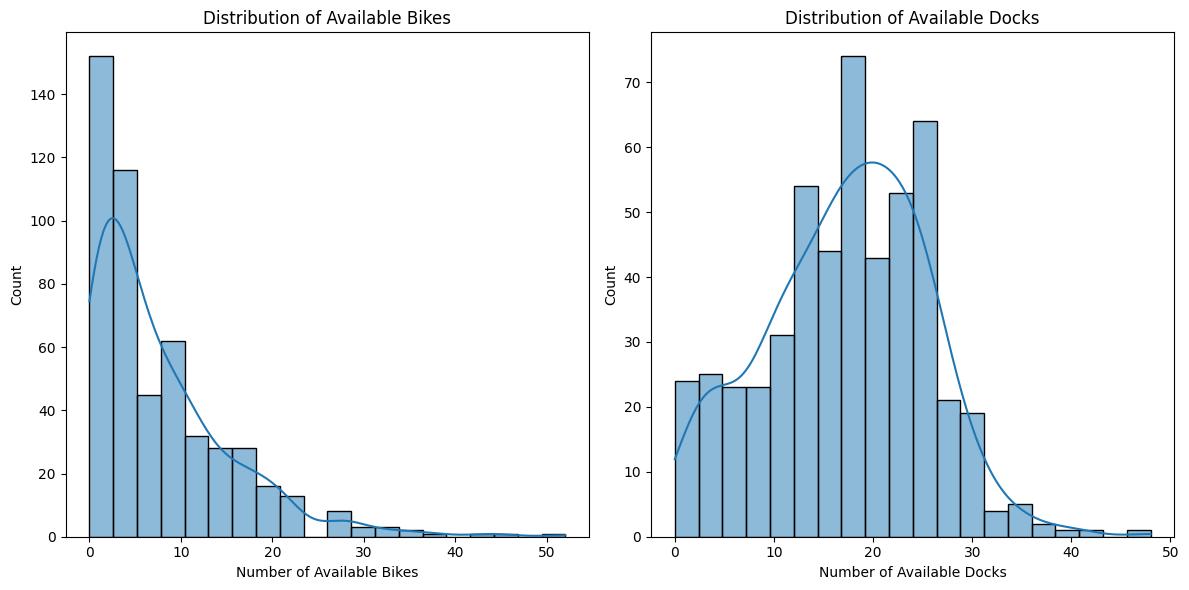

In [75]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(merged_stations_df['num_bikes_available'], bins=20, kde=True)
plt.title('Distribution of Available Bikes')
plt.xlabel('Number of Available Bikes')

plt.subplot(1, 2, 2)
sns.histplot(merged_stations_df['num_docks_available'], bins=20, kde=True)
plt.title('Distribution of Available Docks')
plt.xlabel('Number of Available Docks')
plt.tight_layout()
plt.show()

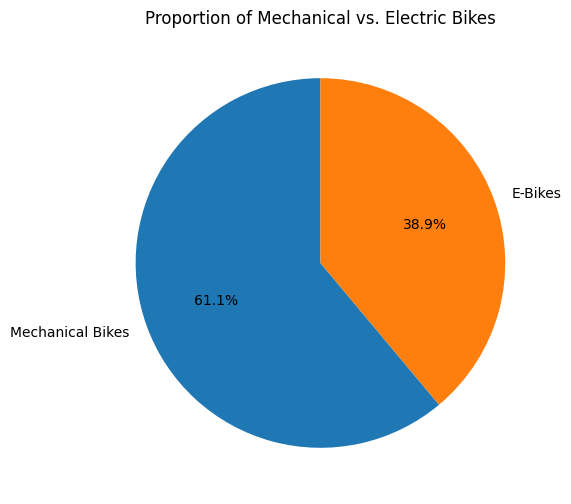

In [76]:
plt.figure(figsize=(10, 6))
bike_types = merged_stations_df[['num_mechanical_bikes', 'num_ebikes']].sum()
plt.pie(bike_types, labels=['Mechanical Bikes', 'E-Bikes'], autopct='%1.1f%%', startangle=90)
plt.title('Proportion of Mechanical vs. Electric Bikes')
plt.show()

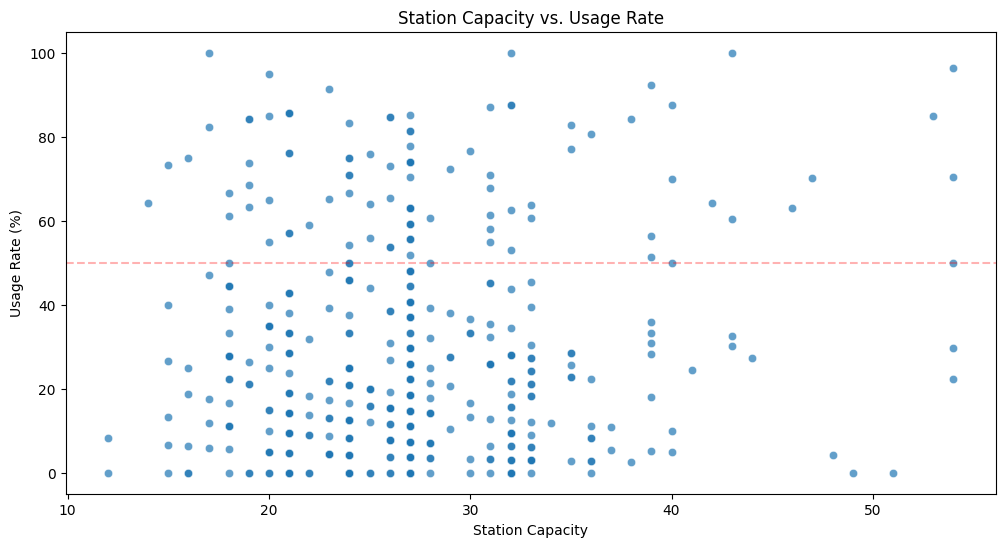

In [77]:
plt.figure(figsize=(12, 6))
merged_stations_df['usage_rate'] = (merged_stations_df['num_bikes_available'] / 
                                    merged_stations_df['capacity']) * 100
sns.scatterplot(x='capacity', y='usage_rate', data=merged_stations_df, alpha=0.7)
plt.axhline(y=50, color='r', linestyle='--', alpha=0.3)
plt.title('Station Capacity vs. Usage Rate')
plt.xlabel('Station Capacity')
plt.ylabel('Usage Rate (%)')
plt.show()

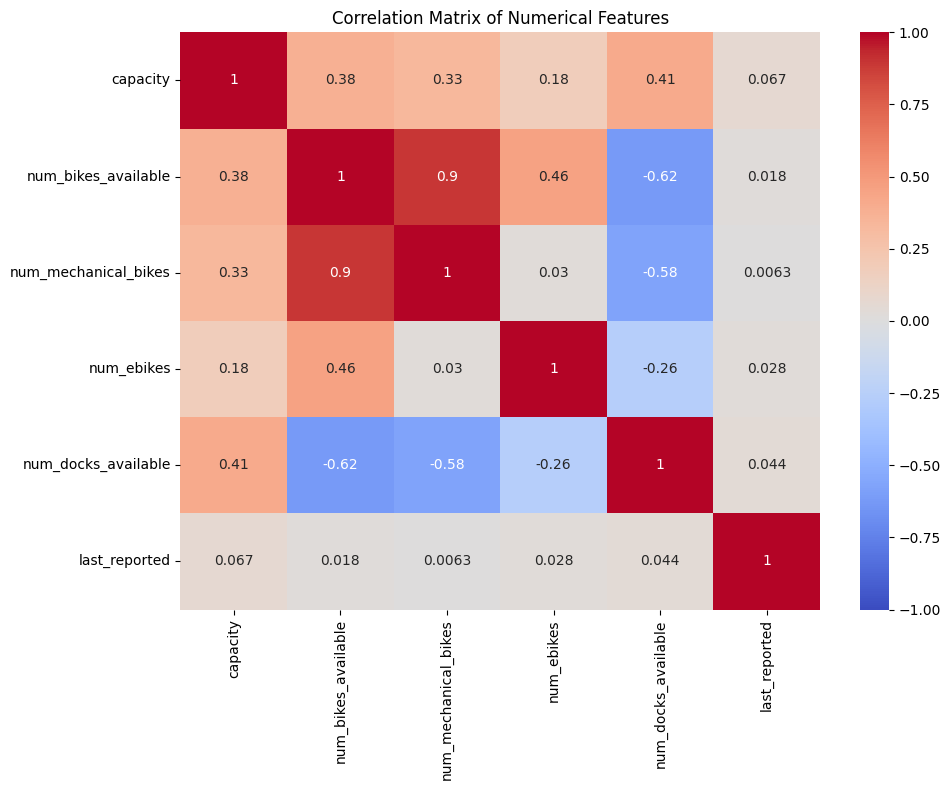

In [78]:
numerical_cols = ['capacity', 'num_bikes_available', 'num_mechanical_bikes', 
                 'num_ebikes', 'num_docks_available', 'last_reported']
corr_matrix = merged_stations_df[numerical_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

In [79]:
merged_stations_df['status'].value_counts()

status
IN_SERVICE     511
MAINTENANCE      1
Name: count, dtype: int64

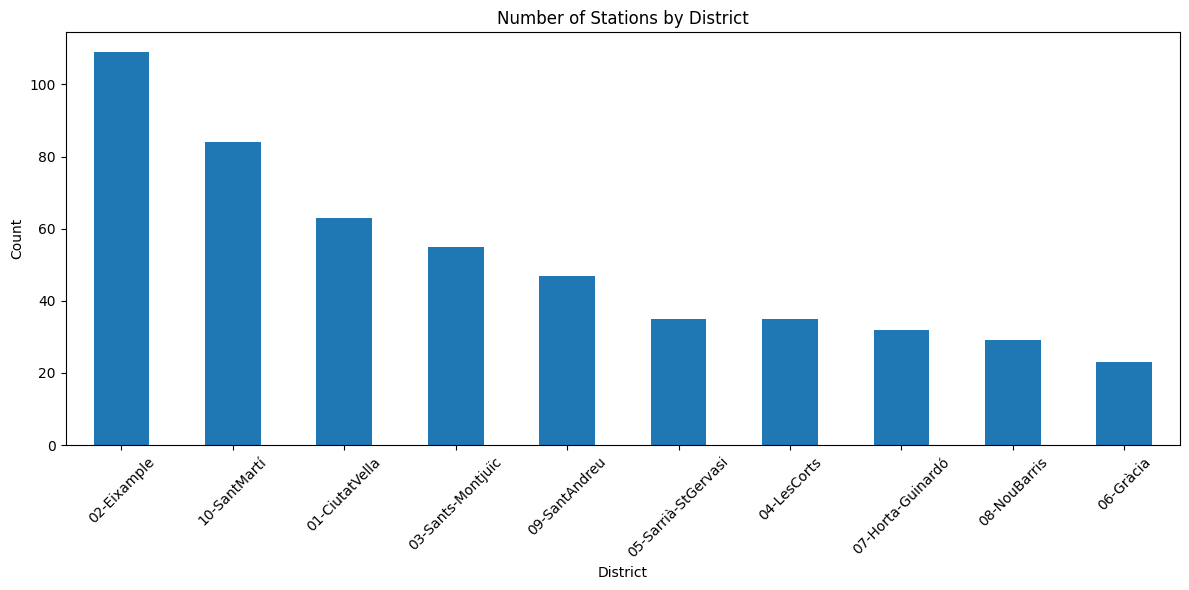

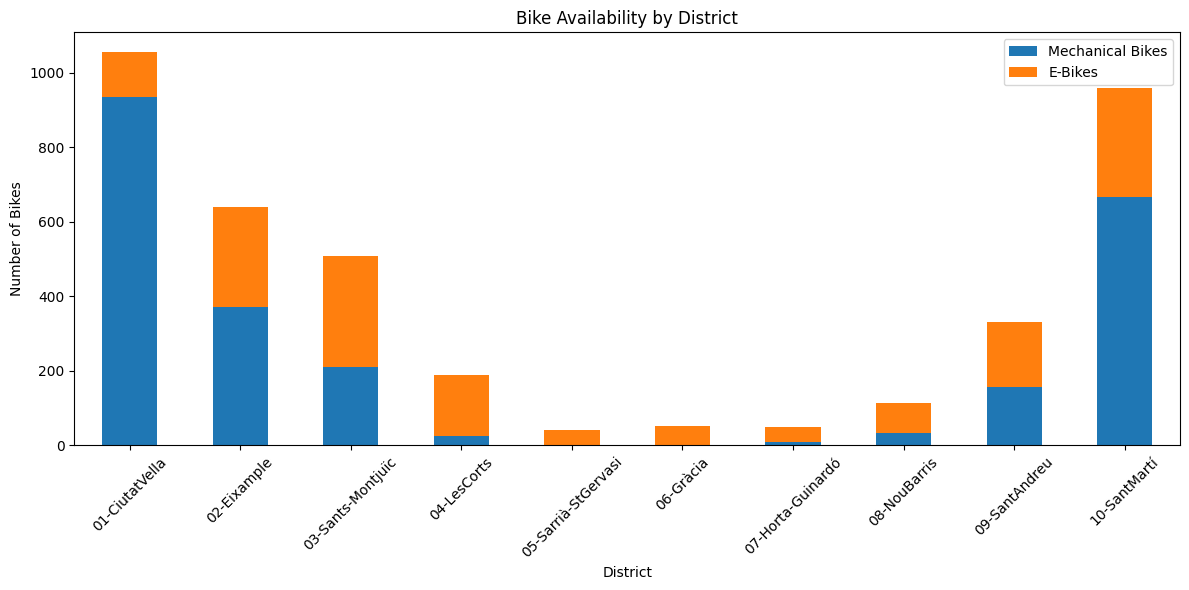

In [80]:
if 'cross_street' in merged_stations_df.columns:
    # Extract district from cross_street
    merged_stations_df['district'] = merged_stations_df['cross_street'].str.split('/').str[0]
    
    district_counts = merged_stations_df['district'].value_counts()
    plt.figure(figsize=(12, 6))
    district_counts.plot(kind='bar')
    plt.title('Number of Stations by District')
    plt.xlabel('District')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Bike availability by district
    district_bike_counts = merged_stations_df.groupby('district')[['num_mechanical_bikes', 'num_ebikes']].sum()
    district_bike_counts.plot(kind='bar', stacked=True, figsize=(12, 6))
    plt.title('Bike Availability by District')
    plt.xlabel('District')
    plt.ylabel('Number of Bikes')
    plt.xticks(rotation=45)
    plt.legend(['Mechanical Bikes', 'E-Bikes'])
    plt.tight_layout()
    plt.show()

In [81]:
print("\nSummary of Bicycle Station Network:")
print(f"Total number of stations: {len(merged_stations_df)}")
print(f"Total capacity across all stations: {merged_stations_df['capacity'].sum()}")
print(f"Total available bikes: {merged_stations_df['num_bikes_available'].sum()}")
print(f"Total mechanical bikes: {merged_stations_df['num_mechanical_bikes'].sum()}")
print(f"Total e-bikes: {merged_stations_df['num_ebikes'].sum()}")
print(f"Total available docks: {merged_stations_df['num_docks_available'].sum()}")
print(f"Percentage of stations that are charging stations: {merged_stations_df['is_charging_station_info'].mean() * 100:.2f}%")


Summary of Bicycle Station Network:
Total number of stations: 512
Total capacity across all stations: 13815
Total available bikes: 3914
Total mechanical bikes: 2402
Total e-bikes: 1530
Total available docks: 8813
Percentage of stations that are charging stations: 100.00%


In [82]:
import folium
from folium.plugins import MarkerCluster, HeatMap
import pandas as pd

# Create base map
center_lat = merged_stations_df['lat'].mean()
center_lon = merged_stations_df['lon'].mean()

m = folium.Map(
    location=[center_lat, center_lon], 
    zoom_start=13,
    tiles='CartoDB positron'
)

# Create feature groups
stations_layer = folium.FeatureGroup(name='Station Markers')
clusters_layer = folium.FeatureGroup(name='Clustered View')
heatmap_layer = folium.FeatureGroup(name='Heatmap View')

# Add a marker cluster
marker_cluster = MarkerCluster()
marker_cluster.add_to(clusters_layer)

# Heat map data
heat_data = []
for idx, row in merged_stations_df.iterrows():
    heat_data.append([row['lat'], row['lon'], row['num_bikes_available']])

# Add heat map
HeatMap(heat_data, radius=15, blur=10).add_to(heatmap_layer)

# Style popups with basic HTML
for idx, row in merged_stations_df.iterrows():
    # Calculate fill ratio
    if row['capacity'] > 0:
        fill_ratio = row['num_bikes_available'] / row['capacity']
    else:
        fill_ratio = 0
    
    # Define colors based on fill ratio
    if fill_ratio < 0.2:
        color = 'red'
        fill_status = "Low availability"
    elif fill_ratio < 0.5:
        color = 'orange'
        fill_status = "Medium availability"
    else:
        color = 'green'
        fill_status = "Good availability"
    
    # Enhanced tooltip with more information
    tooltip_html = f"""
    <div style="font-family: Arial; font-size: 12px; opacity: 0.9; background-color: white; 
                padding: 8px; border-radius: 4px; max-width: 250px; box-shadow: 0 0 4px rgba(0,0,0,0.2);">
        <div style="font-weight: bold; font-size: 14px; margin-bottom: 5px; border-bottom: 1px solid #eee; padding-bottom: 3px;">{row['name']}</div>
        <div><b>{fill_status}</b>: {row['num_bikes_available']}/{row['capacity']} bikes</div>
        <div><b>Mechanical</b>: {row['num_mechanical_bikes']} | <b>E-Bikes</b>: {row['num_ebikes']}</div>
        <div><b>Status</b>: {row['status']}</div>
    </div>
    """
    
    # Detailed popup
    popup_text = f"""
    <div style="font-family: Arial; width: 300px;">
        <h3 style="margin-bottom: 10px; color: #2c3e50;">{row['name']}</h3>
        <table style="width: 100%; border-collapse: collapse;">
            <tr style="background-color: #f5f5f5;">
                <td style="padding: 5px; border-bottom: 1px solid #ddd;"><b>ID:</b></td>
                <td style="padding: 5px; border-bottom: 1px solid #ddd;">{row['station_id']}</td>
            </tr>
            <tr>
                <td style="padding: 5px; border-bottom: 1px solid #ddd;"><b>Address:</b></td>
                <td style="padding: 5px; border-bottom: 1px solid #ddd;">{row['address']}</td>
            </tr>
            <tr style="background-color: #f5f5f5;">
                <td style="padding: 5px; border-bottom: 1px solid #ddd;"><b>Area:</b></td>
                <td style="padding: 5px; border-bottom: 1px solid #ddd;">{row['cross_street'] if pd.notna(row['cross_street']) else 'N/A'}</td>
            </tr>
            <tr>
                <td style="padding: 5px; border-bottom: 1px solid #ddd;"><b>Postal Code:</b></td>
                <td style="padding: 5px; border-bottom: 1px solid #ddd;">{row['post_code']}</td>
            </tr>
            <tr style="background-color: #f5f5f5;">
                <td style="padding: 5px; border-bottom: 1px solid #ddd;"><b>Capacity:</b></td>
                <td style="padding: 5px; border-bottom: 1px solid #ddd;">{row['capacity']}</td>
            </tr>
            <tr>
                <td style="padding: 5px; border-bottom: 1px solid #ddd;"><b>Available Bikes:</b></td>
                <td style="padding: 5px; border-bottom: 1px solid #ddd;">{row['num_bikes_available']} ({fill_ratio:.0%})</td>
            </tr>
            <tr style="background-color: #f5f5f5;">
                <td style="padding: 5px; border-bottom: 1px solid #ddd;"><b>Available Docks:</b></td>
                <td style="padding: 5px; border-bottom: 1px solid #ddd;">{row['num_docks_available']}</td>
            </tr>
            <tr>
                <td style="padding: 5px; border-bottom: 1px solid #ddd;"><b>Mechanical Bikes:</b></td>
                <td style="padding: 5px; border-bottom: 1px solid #ddd;">{row['num_mechanical_bikes']}</td>
            </tr>
            <tr style="background-color: #f5f5f5;">
                <td style="padding: 5px; border-bottom: 1px solid #ddd;"><b>E-Bikes:</b></td>
                <td style="padding: 5px; border-bottom: 1px solid #ddd;">{row['num_ebikes']}</td>
            </tr>
            <tr>
                <td style="padding: 5px; border-bottom: 1px solid #ddd;"><b>Status:</b></td>
                <td style="padding: 5px; border-bottom: 1px solid #ddd;">{row['status']}</td>
            </tr>
            <tr style="background-color: #f5f5f5;">
                <td style="padding: 5px; border-bottom: 1px solid #ddd;"><b>Charging Station:</b></td>
                <td style="padding: 5px; border-bottom: 1px solid #ddd;">{'Yes' if row['is_charging_station_info'] else 'No'}</td>
            </tr>
            <tr>
                <td style="padding: 5px; border-bottom: 1px solid #ddd;"><b>Last Updated:</b></td>
                <td style="padding: 5px; border-bottom: 1px solid #ddd;">{pd.to_datetime(row['last_reported'], unit='s').strftime('%Y-%m-%d %H:%M')}</td>
            </tr>
            <tr style="background-color: #f5f5f5;">
                <td style="padding: 5px; border-bottom: 1px solid #ddd;"><b>Coordinates:</b></td>
                <td style="padding: 5px; border-bottom: 1px solid #ddd;">{row['lat']:.5f}, {row['lon']:.5f}</td>
            </tr>
        </table>
    </div>
    """
    
    # Add circle marker to stations layer with enhanced tooltip
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=8 + (row['capacity'] / 20),  # Size indicates capacity
        popup=folium.Popup(popup_text, max_width=350),
        tooltip=folium.Tooltip(tooltip_html, sticky=True),
        fill=True,
        fill_color=color,
        color='black',
        weight=1,
        fill_opacity=0.7
    ).add_to(stations_layer)
    
    # Add marker to cluster
    folium.Marker(
        location=[row['lat'], row['lon']],
        popup=folium.Popup(popup_text, max_width=350),
        tooltip=folium.Tooltip(tooltip_html, sticky=True),
        icon=folium.Icon(color=color, icon='bicycle', prefix='fa')
    ).add_to(marker_cluster)

# Add layers to map
stations_layer.add_to(m)
clusters_layer.add_to(m)
heatmap_layer.add_to(m)

# Add simple legend as HTML
legend_html = """
<div style="position: fixed; 
            bottom: 10px; 
            left: 10px; 
            width: auto; 
            height: auto; 
            background-color: white; 
            border-radius: 4px; 
            box-shadow: 0 0 10px rgba(0,0,0,0.2); 
            padding: 10px; 
            z-index: 1000; 
            font-family: Arial;
            font-size: 12px;">
    <div style="font-weight: bold; margin-bottom: 5px;">Station Availability</div>
    <div style="display: flex; align-items: center; margin-bottom: 4px;">
        <div style="width: 12px; height: 12px; border-radius: 50%; background-color: red; margin-right: 5px;"></div>
        <div>Low (&lt;20%)</div>
    </div>
    <div style="display: flex; align-items: center; margin-bottom: 4px;">
        <div style="width: 12px; height: 12px; border-radius: 50%; background-color: orange; margin-right: 5px;"></div>
        <div>Medium (20-50%)</div>
    </div>
    <div style="display: flex; align-items: center;">
        <div style="width: 12px; height: 12px; border-radius: 50%; background-color: green; margin-right: 5px;"></div>
        <div>Good (&gt;50%)</div>
    </div>
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

# Add info box
info_html = f"""
<div style="position: fixed; 
            bottom: 10px; 
            right: 10px; 
            width: auto; 
            height: auto; 
            background-color: white; 
            border-radius: 4px; 
            box-shadow: 0 0 10px rgba(0,0,0,0.2); 
            padding: 10px; 
            z-index: 1000; 
            font-family: Arial;
            font-size: 12px;">
    <div style="font-weight: bold; margin-bottom: 5px;">Barcelona Bicycle Network</div>
    <div>Total Stations: {len(merged_stations_df)}</div>
    <div>Total Bikes Available: {merged_stations_df['num_bikes_available'].sum()}</div>
    <div>Mechanical Bikes: {merged_stations_df['num_mechanical_bikes'].sum()}</div>
    <div>E-Bikes: {merged_stations_df['num_ebikes'].sum()}</div>
</div>
"""
m.get_root().html.add_child(folium.Element(info_html))

# Add layer control
folium.LayerControl().add_to(m)

m.save("../data/bicycle_stations/bicycle_stations_map.html")

# January 2025

In [83]:
# read into df
january_2025_df = pd.read_csv('../data/bicycle_stations/2025_01_Gener_BicingNou_INFORMACIO.csv', nrows=100000)

In [84]:
january_2025_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 19 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   station_id              100000 non-null  int64  
 1   name                    100000 non-null  object 
 2   physical_configuration  100000 non-null  object 
 3   lat                     100000 non-null  float64
 4   lon                     100000 non-null  float64
 5   altitude                98639 non-null   float64
 6   address                 100000 non-null  object 
 7   cross_street            99612 non-null   object 
 8   post_code               99612 non-null   float64
 9   capacity                100000 non-null  int64  
 10  is_charging_station     100000 non-null  bool   
 11  short_name              100000 non-null  int64  
 12  nearby_distance         100000 non-null  int64  
 13  x_ride_code_support     100000 non-null  bool   
 14  rental_uris          

In [85]:
# isna
january_2025_df.isna().sum()

station_id                     0
name                           0
physical_configuration         0
lat                            0
lon                            0
altitude                    1361
address                        0
cross_street                 388
post_code                    388
capacity                       0
is_charging_station            0
short_name                     0
nearby_distance                0
x_ride_code_support            0
rental_uris               100000
is_valet_station           99612
last_updated                   0
ttl                            0
V1                        100000
dtype: int64

In [113]:
from datetime import datetime, timedelta
# load last updated into a list
last_updated_list_timestamp = january_2025_df['last_updated'].tolist()
# 1735686001: convert to datetime
last_updated_list = [datetime.fromtimestamp(timestamp) for timestamp in last_updated_list_timestamp]
# sort the list
last_updated_list.sort()
# print the first 10 dates
print(last_updated_list[:1])
# print the last 10 dates
print(last_updated_list[-1:])
# print the number of unique dates
for i in range(len(last_updated_list)):
    dist = last_updated_list[i] - last_updated_list[i-1]
    if dist > timedelta(minutes=5.05):
        print(i, i-1)
        print(f"The difference between {last_updated_list[i]} and {last_updated_list[i-1]} is {dist}")



[datetime.datetime(2025, 1, 1, 0, 0, 1)]
[datetime.datetime(2025, 1, 1, 16, 10, 2)]
1026 1025
The difference between 2025-01-01 00:10:04 and 2025-01-01 00:04:59 is 0:05:05
9234 9233
The difference between 2025-01-01 01:30:04 and 2025-01-01 01:25:00 is 0:05:04
19494 19493
The difference between 2025-01-01 03:10:05 and 2025-01-01 03:05:00 is 0:05:05
25650 25649
The difference between 2025-01-01 04:10:09 and 2025-01-01 04:05:00 is 0:05:09
29241 29240
The difference between 2025-01-01 04:45:04 and 2025-01-01 04:40:00 is 0:05:04
32832 32831
The difference between 2025-01-01 05:20:04 and 2025-01-01 05:15:00 is 0:05:04
34371 34370
The difference between 2025-01-01 05:35:04 and 2025-01-01 05:29:59 is 0:05:05
36936 36935
The difference between 2025-01-01 06:00:05 and 2025-01-01 05:54:59 is 0:05:06
62586 62585
The difference between 2025-01-01 10:10:04 and 2025-01-01 10:05:00 is 0:05:04
69768 69767
The difference between 2025-01-01 11:20:04 and 2025-01-01 11:14:59 is 0:05:05
75924 75923
The diff

In [114]:
january_2025_df.head()

,station_id,name,physical_configuration,lat,lon,altitude,address,cross_street,post_code,capacity,is_charging_station,short_name,nearby_distance,x_ride_code_support,rental_uris,is_valet_station,last_updated,ttl,V1
0,1,"GRAN VIA CORTS CATALANES, 760",ELECTRICBIKESTATION,41.397978,2.180107,16.0,"GRAN VIA CORTS CATALANES, 760",02-Eixample/05-el Fort Pienc,8013.0,46,True,1,1000,True,NaN,NaN,1735686001,0,NaN
1,2,"C/ ROGER DE FLOR, 126",ELECTRICBIKESTATION,41.395488,2.177198,17.0,"C/ ROGER DE FLOR, 126",02-Eixample/05-el Fort Pienc,8013.0,29,True,2,1000,True,NaN,NaN,1735686001,0,NaN
2,3,"C/ NÀPOLS, 82",ELECTRICBIKESTATION,41.394156,2.181331,11.0,"C/ NÀPOLS, 82",02-Eixample/05-el Fort Pienc,8013.0,27,True,3,1000,True,NaN,NaN,1735686001,0,NaN
3,4,"C/ RIBES, 13",ELECTRICBIKESTATION,41.393317,2.181248,8.0,"C/ RIBES, 13",02-Eixample/05-el Fort Pienc,8013.0,21,True,4,1000,True,NaN,NaN,1735686001,0,NaN
4,5,"PG. LLUIS COMPANYS, 11 (ARC TRIOMF)",ELECTRICBIKESTATION,41.391103,2.180176,7.0,"PG. LLUIS COMPANYS, 11 (ARC TRIOMF)","01-CiutatVella/04-Sant Pere, Santa Caterina i ...",8018.0,39,True,5,1000,True,NaN,NaN,1735686001,0,NaN


In [5]:
station_status_2025_january_df = pd.read_csv('../data/bicycle_stations/2025_01_Gener_BicingNou_ESTACIONS.csv', nrows=100000)

In [6]:
station_status_2025_january_df.head()

,station_id,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,num_docks_available,last_reported,is_charging_station,status,is_installed,is_renting,is_returning,traffic,last_updated,ttl,V1
0,1,14,8,6,31,1735685985,True,IN_SERVICE,1,1,1,NaN,1735686004,1,NaN
1,2,20,18,2,7,1735685925,True,IN_SERVICE,1,1,1,NaN,1735686004,1,NaN
2,3,23,15,8,3,1735685825,True,IN_SERVICE,1,1,1,NaN,1735686004,1,NaN
3,4,18,11,7,3,1735685919,True,IN_SERVICE,1,1,1,NaN,1735686004,1,NaN
4,5,13,10,3,26,1735685957,True,IN_SERVICE,1,1,1,NaN,1735686004,1,NaN


In [7]:
station_status_2025_january_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   station_id                            100000 non-null  int64  
 1   num_bikes_available                   100000 non-null  int64  
 2   num_bikes_available_types.mechanical  100000 non-null  int64  
 3   num_bikes_available_types.ebike       100000 non-null  int64  
 4   num_docks_available                   100000 non-null  int64  
 5   last_reported                         100000 non-null  int64  
 6   is_charging_station                   100000 non-null  bool   
 7   status                                100000 non-null  object 
 8   is_installed                          100000 non-null  int64  
 9   is_renting                            100000 non-null  int64  
 10  is_returning                          100000 non-null  int64  
 11  t